# Corona Virus Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rawData = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")

In [3]:
dataFrames = dict(states={}, counties={})
columns = ['cases', 'deaths']

def getTotal(): 
    if not "total" in dataFrames:
        dataFrames["total"] =rawData.groupby('date').sum()[columns]
    return dataFrames["total"]

def getState(state):
    if not state in dataFrames["states"]:
        statedf = rawData[rawData.state==state].groupby('date').sum()[columns]
        if statedf.empty:
            print (state + " is not in the data, did you spell it right? capitalization?")
            return 
        else:
            dataFrames["states"][state] = statedf
    return dataFrames["states"][state]

def getCounty(county):
    if not county in dataFrames["counties"]:
        countydf = rawData[rawData.county==county].groupby('date').sum()[columns]
        if countydf.empty:
            print(county + " is not in the data, did you spell it right? capitalization?")
            return
        else:
            dataFrames["counties"][county] = countydf
    return dataFrames["counties"][county]
        

In [4]:
getTotal().tail(2) # last two dates data to check how recent this data is


cases  deaths
date                      
2020-04-02  243719    5496
2020-04-03  276091    7136

In [5]:
def fitExponential(series):
    series = series.dropna()
    series = series[series>0]
    logseries = np.log(series)
    n = len(logseries)
    rate, intercept = np.polyfit(np.arange(n), logseries, 1) 
    base = np.exp(intercept)
    return (rate, base, n) 


In [6]:
def plotFitted(series, name, log=True): 
    (rate, base, n) = fitExponential(series)
    x = np.arange(n)
    series = series[-n:]
    if log:
        plt.semilogy()
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    sbn.scatterplot(x, series, label=f"{name} actual")
    sbn.lineplot(x, base * np.exp(rate*x) , label=f"{name} expected with constant exponential growth")
    plt.show()

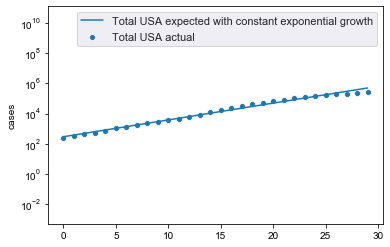

In [7]:
plotFitted(getTotal()["cases"][-30:], "Total USA")

In [8]:
def growthRateAnalysis(series, name, n=30):
    rate, base, n = fitExponential(series[-n:])
    name = f"{name} {series.name}"
    formula = f"{series.name} = {np.round(base, 2)} * exp({np.round(rate, 4)} * day)"
    dailyGrowth = np.round(100 * (np.exp(rate) - 1), 2)
    daysToDoubling = np.round(np.log(2)/rate, 2)
    print(f"{name} exponential formula fitted with {n} points:")
    print(formula)
    print(f"fitted daily growth rate: {dailyGrowth} %, fitted days to doubling: {daysToDoubling}")
    deltas = series.diff(1)
    rates = 100*deltas/series
    data = {
        f"{name} day to day growth rate (%)":rates, 
        f"{name} 3 day moving average":rates.rolling(window=3).mean(), 
        f"{name} 5 day moving average":rates.rolling(window=5).mean(), 
    }
    df = pd.DataFrame(data).dropna()[-n:]
    gr = df.tail(1)[f"{name} 5 day moving average"].values[0]
    dailyGrowth = np.round(gr, 2)
    daysToDoubling = np.round(np.log(2)*100/gr, 2)
    print(f"actual daily growth rate: {dailyGrowth} %, actual days to doubling: {daysToDoubling}")    
    sbn.lineplot(data=df)
    plt.show()
    plotFitted(series[-n:], name)


Total USA cases exponential formula fitted with 30 points:
cases = 288.65 * exp(0.2574 * day)
fitted daily growth rate: 29.36 %, fitted days to doubling: 2.69
actual daily growth rate: 12.43 %, actual days to doubling: 5.58


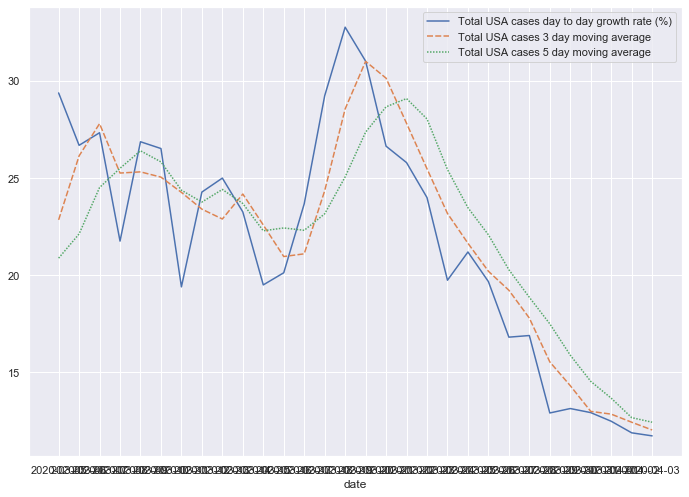

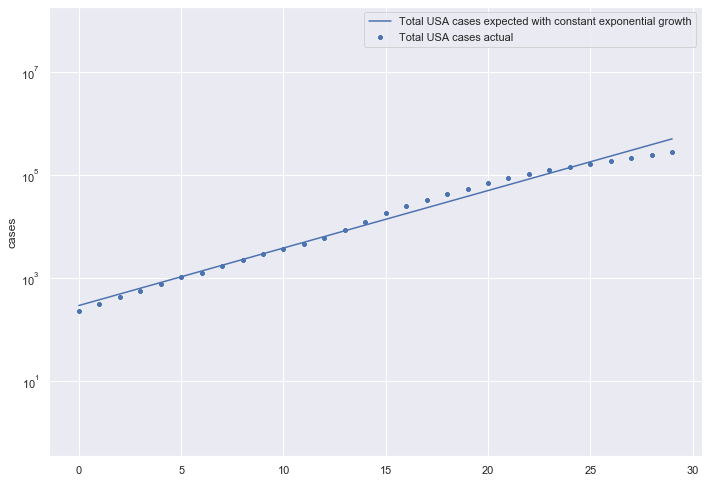

In [9]:
growthRateAnalysis(getTotal()['cases'], "Total USA")

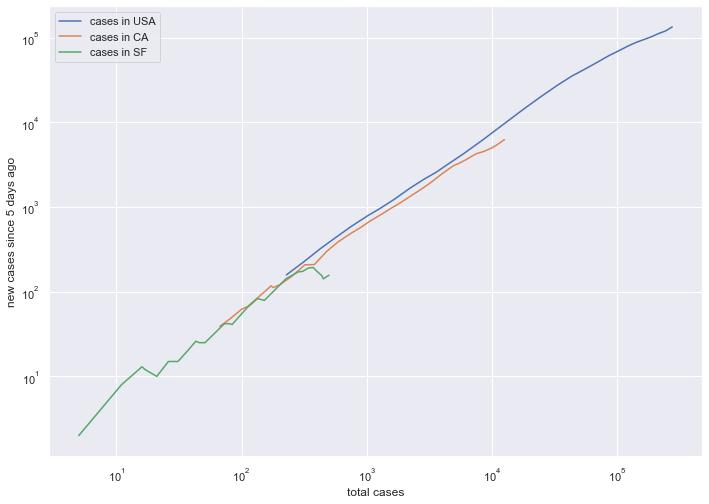

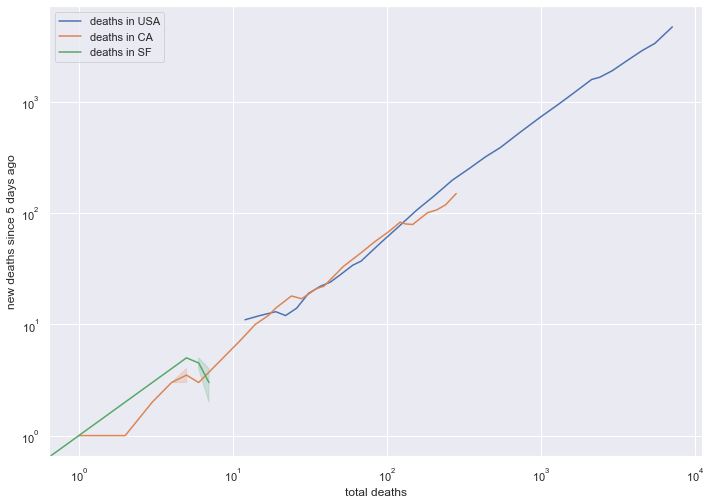

In [10]:
def trajectoryPlot(series, name):
    deltas = series.diff(5)
    fullname = f"{series.name} in {name}"
    x = f"total {series.name}"
    y = f"new {series.name} since 5 days ago"
    data = {x: series, y: deltas}
    plt.loglog()
    df = pd.DataFrame(data).dropna()[-30:]
    sbn.lineplot(x, y, data=df, label=fullname)
    
trajectoryPlot(getTotal()['cases'], "USA")
trajectoryPlot(getState("California")['cases'], "CA")
trajectoryPlot(getCounty("San Francisco")["cases"], "SF")
plt.show()
trajectoryPlot(getTotal()['deaths'], "USA")
trajectoryPlot(getState("California")['deaths'], "CA")
trajectoryPlot(getCounty("San Francisco")["deaths"], "SF")
plt.show()

In [11]:
def laggedPlot(df, name):
    vals = df.copy()
    vals = df.dropna()[df.cases > 0]
    # show correlation with wide range of time lags
    for i in range(30):
        vals[i] = df.cases.shift(i)
    vals = vals.drop(columns='cases')
    vals = vals[vals.deaths > 0][-20:]
    corrs = vals.corr()[['deaths']].drop('deaths')
    lc = np.log(vals).corr()[['deaths']].drop('deaths')
    lc[0] = lc.deaths
    for i in [3, 5, 7]:
        lc[i] = lc.deaths.rolling(i).mean()
    lc = lc.dropna()
    corrdata = {
        f"{name} correlation of log of deaths to log of cases by # of days ago": lc[0],
        f"{name} correlation 3 day moving average": lc[3],
        f"{name} correlation 5 day moving average": lc[5],
        f"{name} correlation 7 day moving average": lc[7],
    }
    corrsdf = pd.DataFrame(corrdata)
    print(f"Correlations for {name}:")
    sbn.lineplot(data=corrsdf)
    plt.show()
    # dig deeper into an interesting set of time lags
    values = vals[["deaths"]].copy()
    ratios = vals[["deaths"]].copy()
    interesting = [7, 14]
    for i in [0, 3, 5, 7]:
        l = lc[i].dropna()
        lmax = l[l==max(l)] # max at this correlation moving average
        interesting += list(lmax.index)
    for i in sorted(list(set(interesting))):
        values[f"{name} cases {i} days ago"] = vals[i]
        ratios[f"{name} deaths/cases {i} days ago"] = vals.deaths/vals[i]
    ratios = ratios.drop(columns=['deaths'])
    print(f"Deaths vs Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=values, dashes=False)
    plt.show()
    print(f"Deaths / Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=ratios, dashes=False)
    plt.show()

    

Correlations for USA:


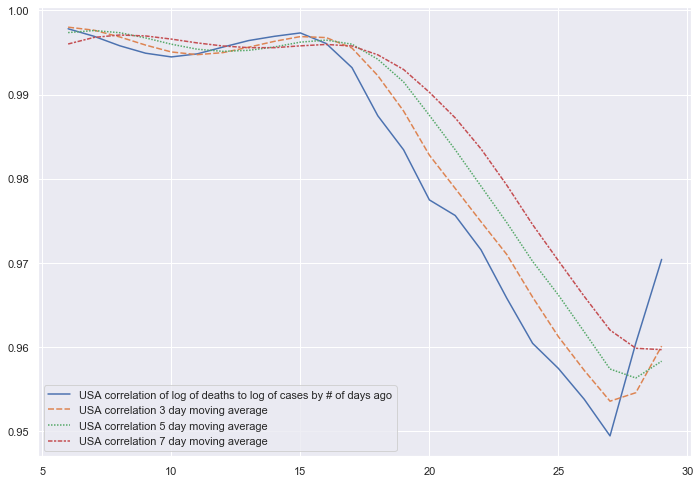

Deaths vs Lagged Values For USA:


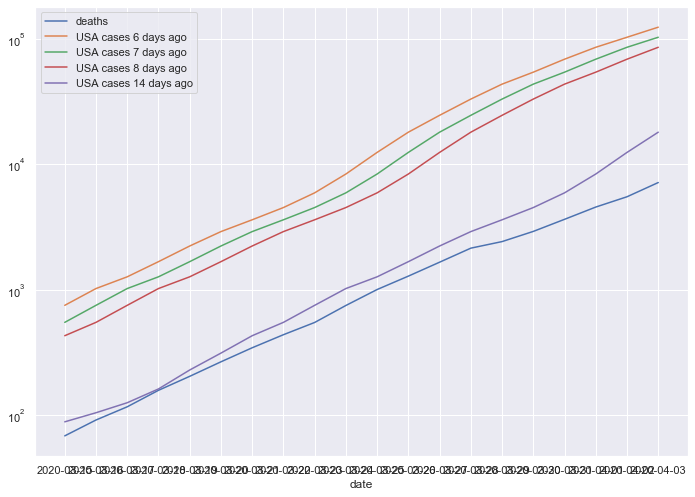

Deaths / Lagged Values For USA:


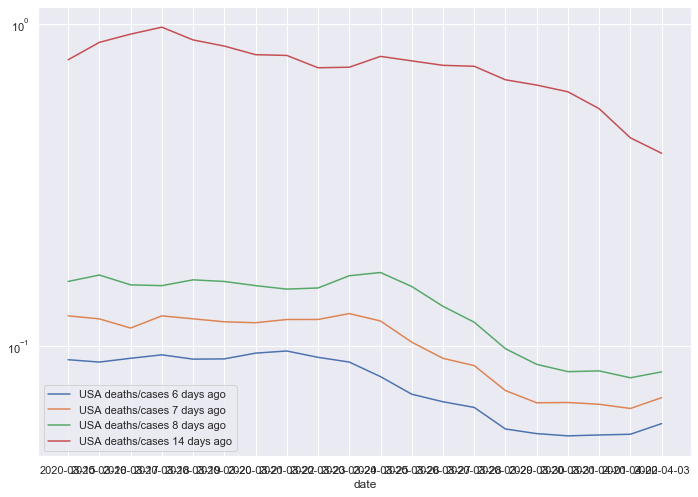

Correlations for CA:


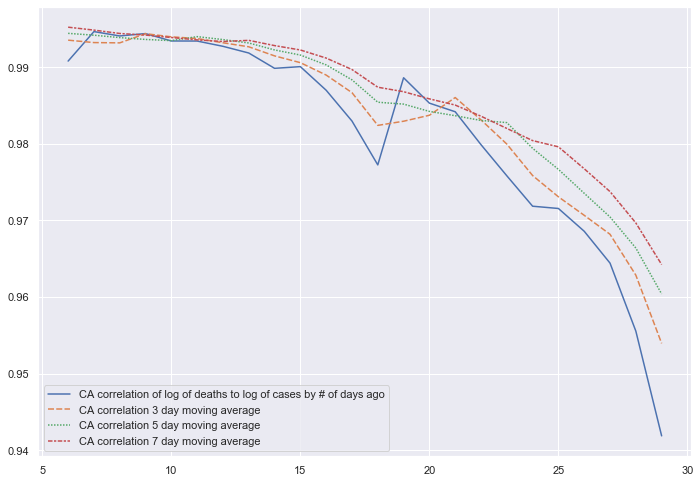

Deaths vs Lagged Values For CA:


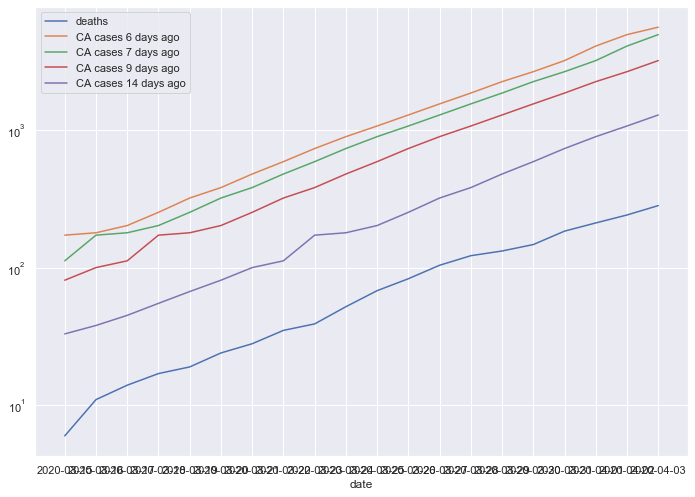

Deaths / Lagged Values For CA:


Correlations for SF:


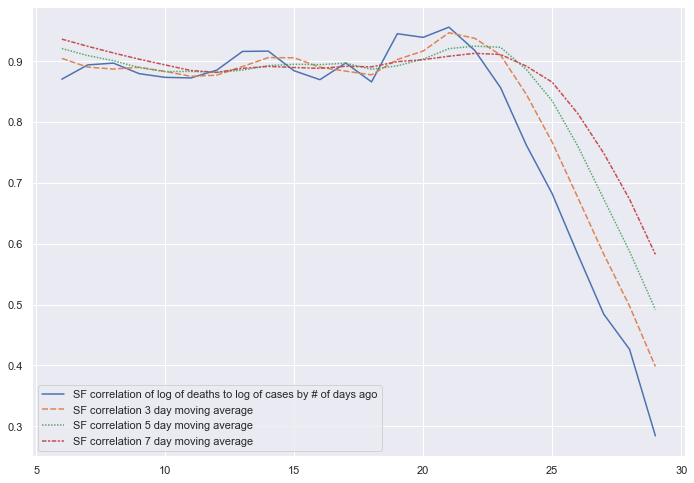

Deaths vs Lagged Values For SF:


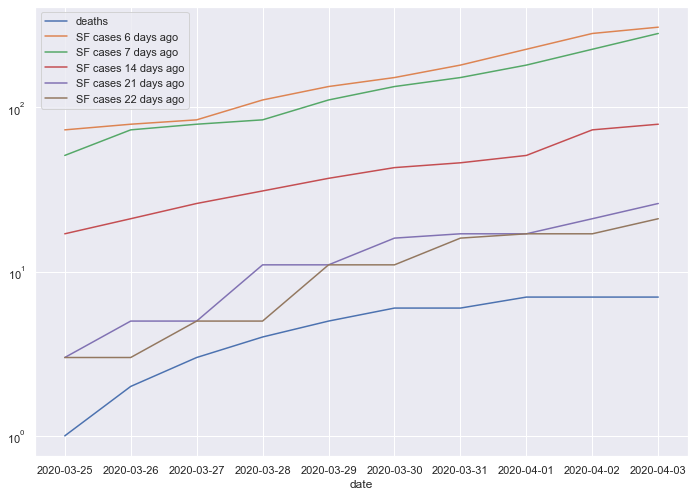

Deaths / Lagged Values For SF:


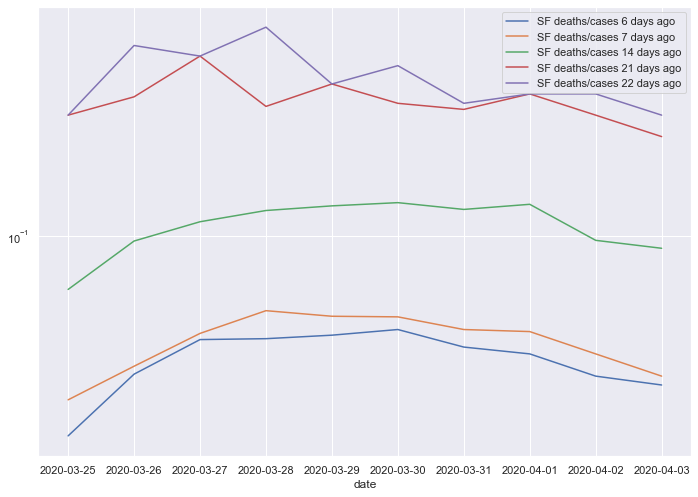

In [12]:
laggedPlot(getTotal(), "USA")
laggedPlot(getState("California"), "CA")
laggedPlot(getCounty("San Francisco"), "SF")

In [13]:
def analyse(counties=[], states=[], n=20):
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    names = counties + states + ["USA total:"]
    rates= []
    dfs = [getCounty(c) for c in counties] + [getState(s) for s in states] + [getTotal()] 
    print("Trajectory Plots to see if the curve is flattening:")
    for col in ["cases", "deaths"]:
        for df, name in zip(dfs, names):
            trajectoryPlot(df[col], name)
        plt.show()
    for df, name in zip(dfs, names):
        print(f"\n### Analysis for {name:} ###\n")
        growthRateAnalysis(df["cases"], name)
        growthRateAnalysis(df["deaths"], name)
        print(f"Trajectory plots for {name}, to see when the curve starts flattening")
        trajectoryPlot(df.cases, name)
        trajectoryPlot(df.deaths, name)
        plt.show()
        laggedPlot(df, name)


        
    
    

Trajectory Plots to see if the curve is flattening:


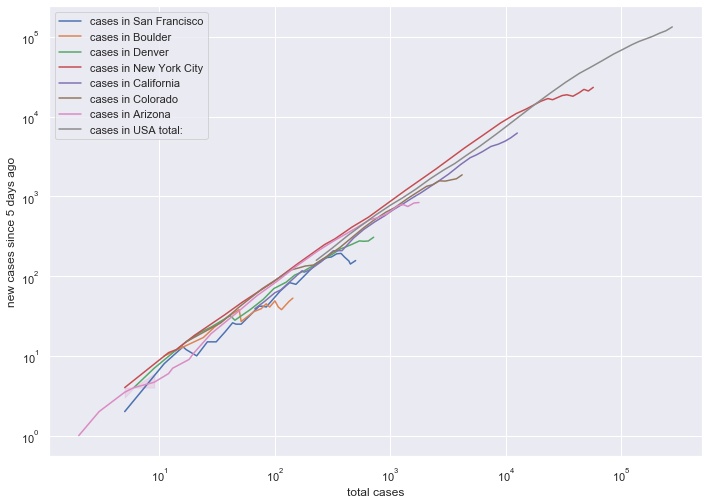

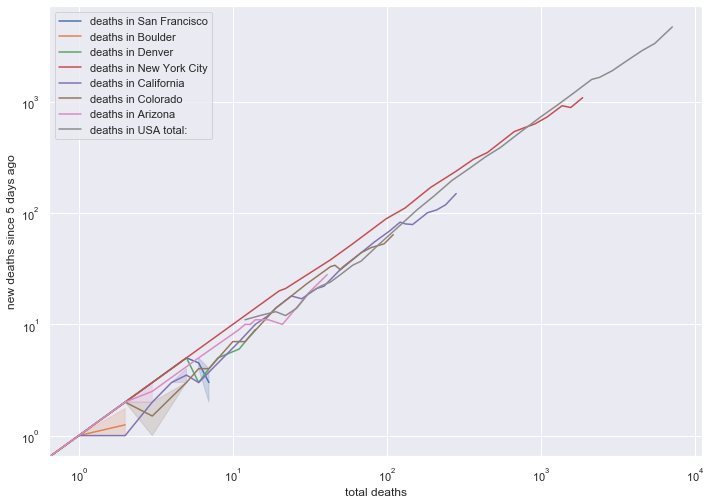


### Analysis for San Francisco ###

San Francisco cases exponential formula fitted with 30 points:
cases = 6.9 * exp(0.1592 * day)
fitted daily growth rate: 17.25 %, fitted days to doubling: 4.36
actual daily growth rate: 7.23 %, actual days to doubling: 9.59


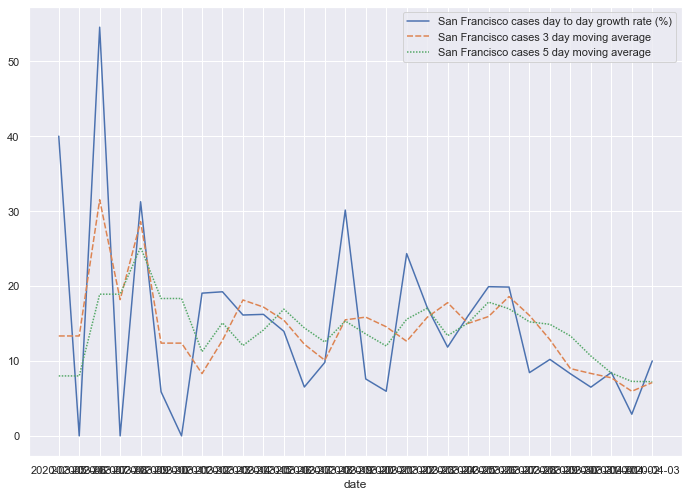

San Francisco deaths exponential formula fitted with 10 points:
deaths = 1.73 * exp(0.1934 * day)
fitted daily growth rate: 21.34 %, fitted days to doubling: 3.58
actual daily growth rate: 6.19 %, actual days to doubling: 11.2


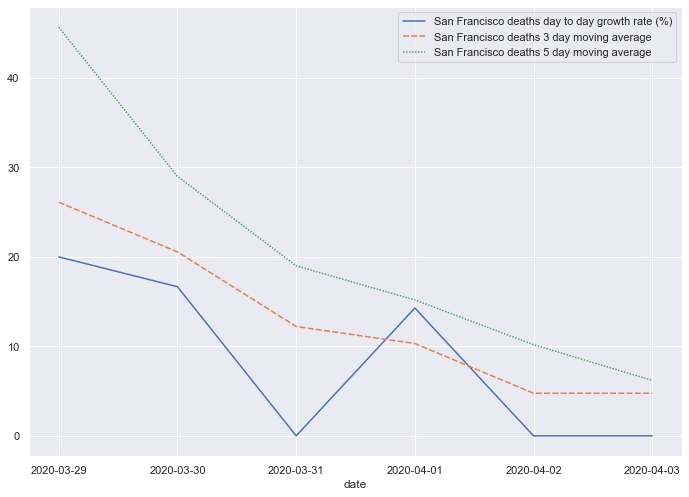

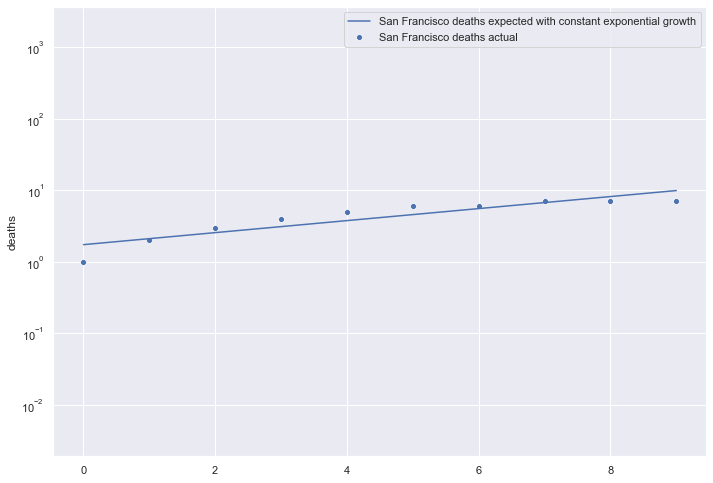

Trajectory plots for San Francisco, to see when the curve starts flattening


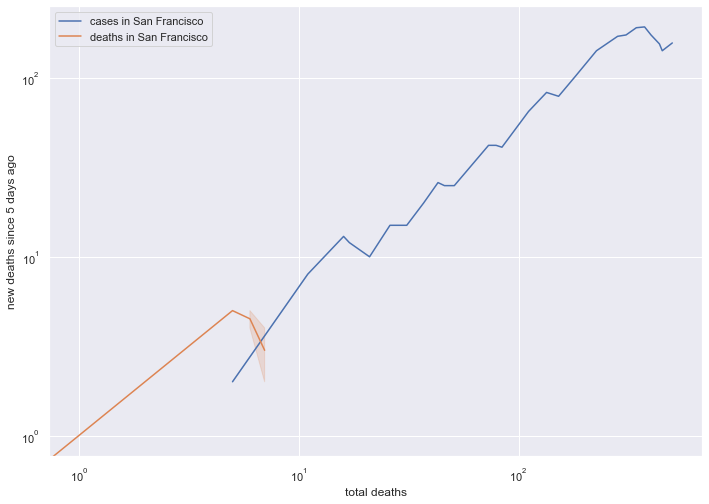

Correlations for San Francisco:


Deaths vs Lagged Values For San Francisco:


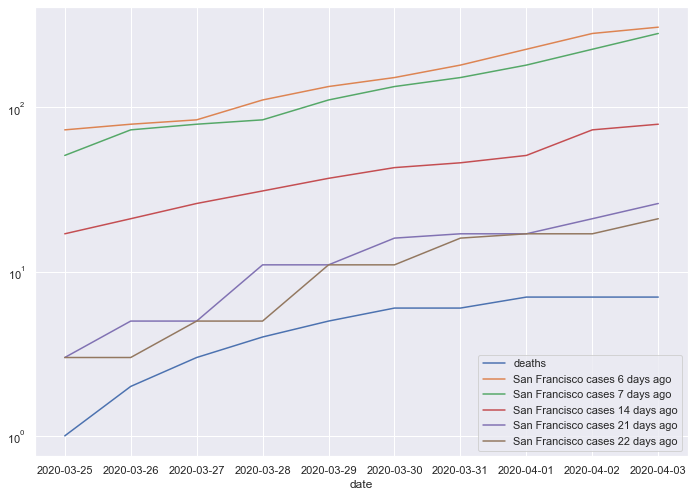

Deaths / Lagged Values For San Francisco:


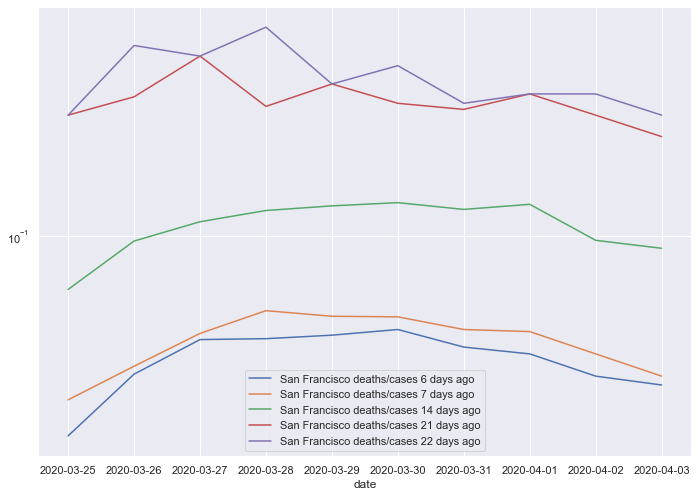


### Analysis for Boulder ###

Boulder cases exponential formula fitted with 21 points:
cases = 4.62 * exp(0.1967 * day)
fitted daily growth rate: 21.73 %, fitted days to doubling: 3.52
actual daily growth rate: 8.8 %, actual days to doubling: 7.87


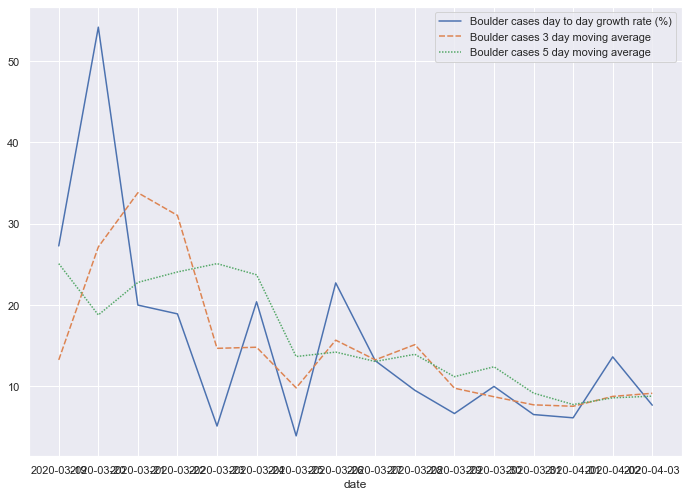

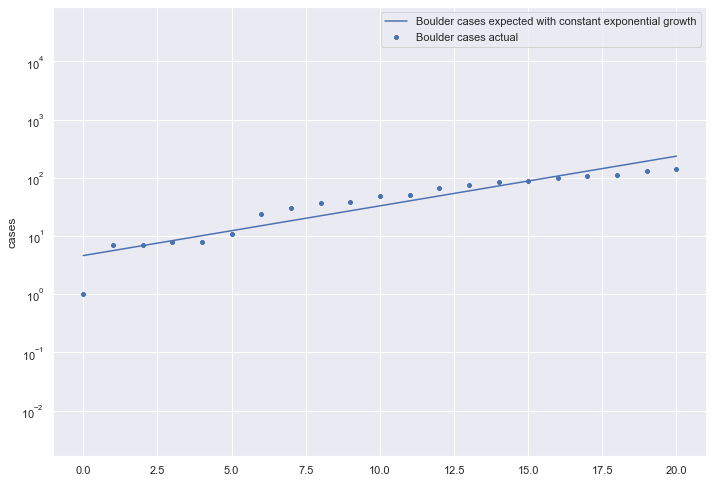

Boulder deaths exponential formula fitted with 8 points:
deaths = 0.89 * exp(0.132 * day)
fitted daily growth rate: 14.11 %, fitted days to doubling: 5.25
actual daily growth rate: 10.0 %, actual days to doubling: 6.93


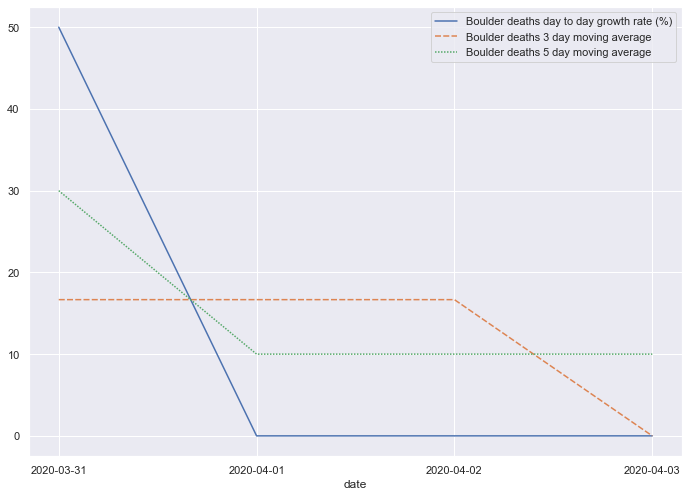

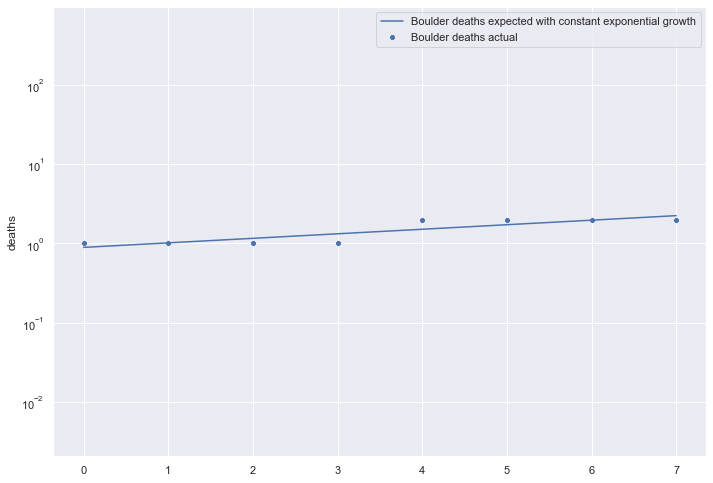

Trajectory plots for Boulder, to see when the curve starts flattening


Correlations for Boulder:


Deaths vs Lagged Values For Boulder:


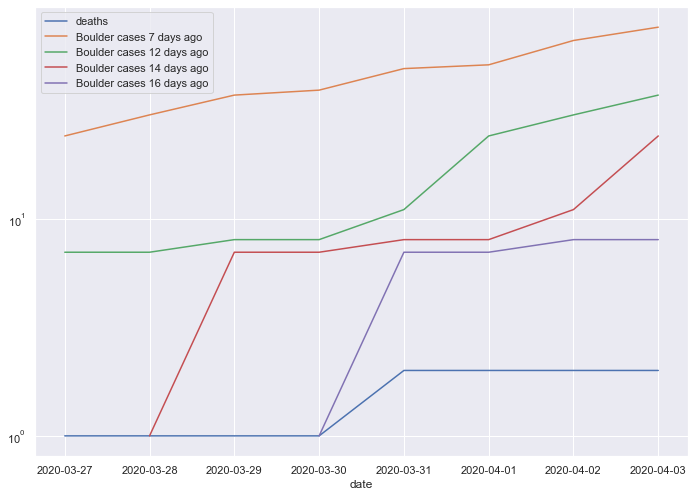

Deaths / Lagged Values For Boulder:



### Analysis for Denver ###

Denver cases exponential formula fitted with 29 points:
cases = 2.44 * exp(0.225 * day)
fitted daily growth rate: 25.23 %, fitted days to doubling: 3.08
actual daily growth rate: 10.61 %, actual days to doubling: 6.53


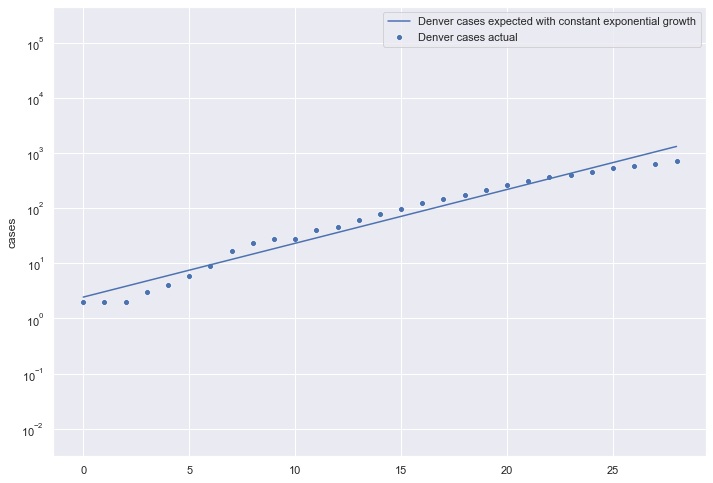

Denver deaths exponential formula fitted with 10 points:
deaths = 2.57 * exp(0.1761 * day)
fitted daily growth rate: 19.25 %, fitted days to doubling: 3.94
actual daily growth rate: 18.43 %, actual days to doubling: 3.76


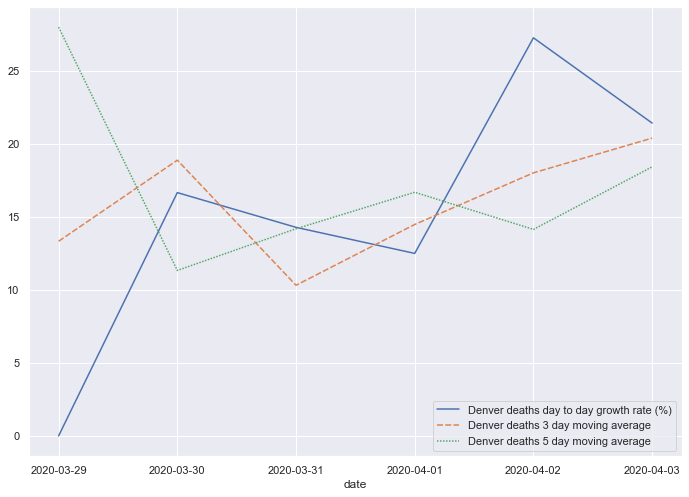

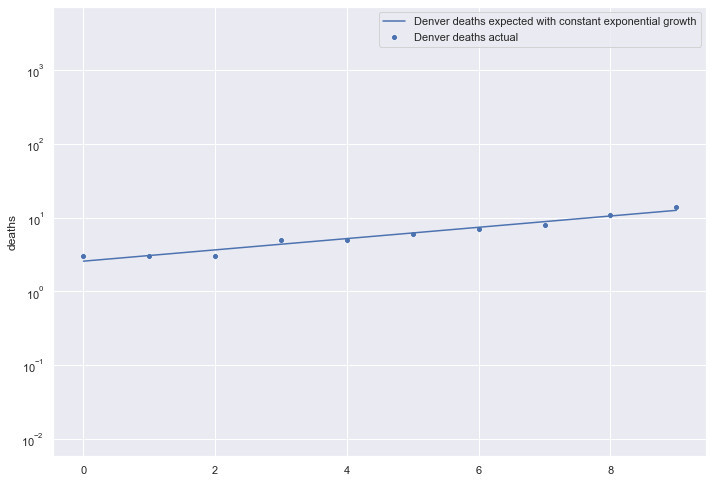

Trajectory plots for Denver, to see when the curve starts flattening


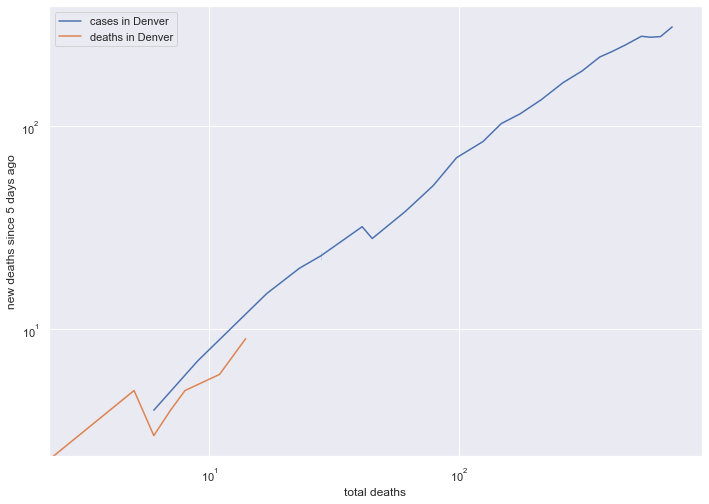

Correlations for Denver:


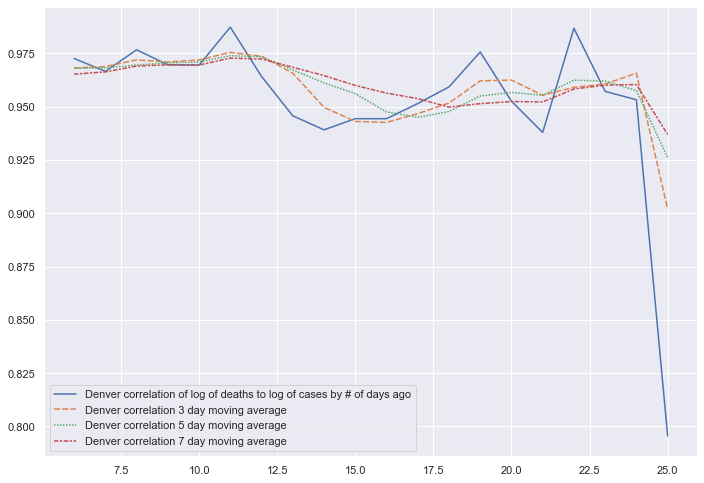

Deaths vs Lagged Values For Denver:


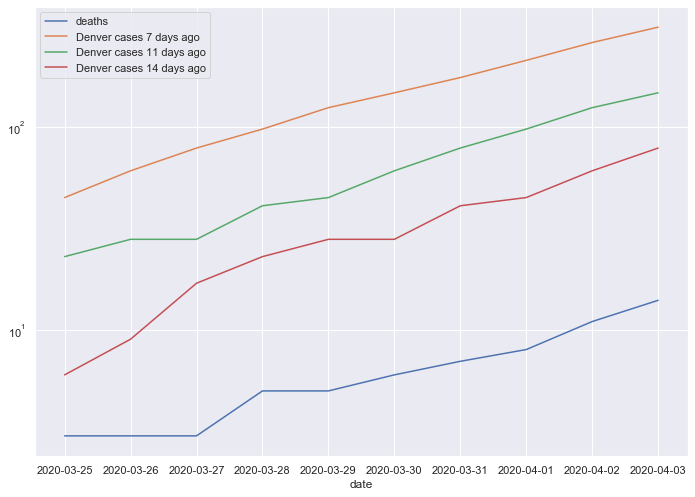

Deaths / Lagged Values For Denver:


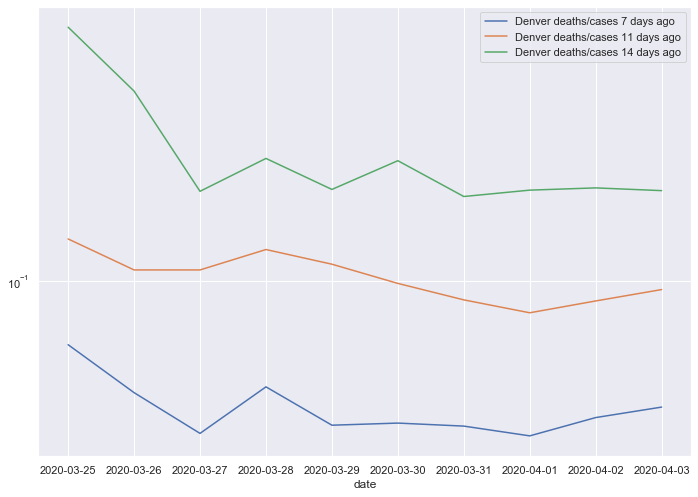


### Analysis for New York City ###

New York City cases exponential formula fitted with 30 points:
cases = 8.33 * exp(0.3531 * day)
fitted daily growth rate: 42.35 %, fitted days to doubling: 1.96
actual daily growth rate: 9.98 %, actual days to doubling: 6.94


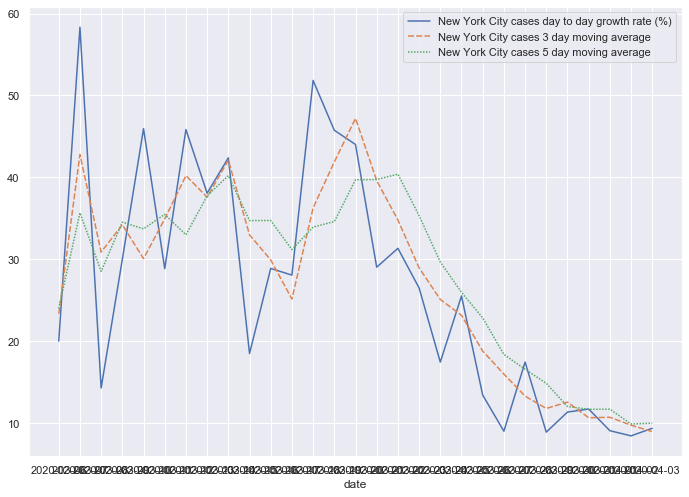

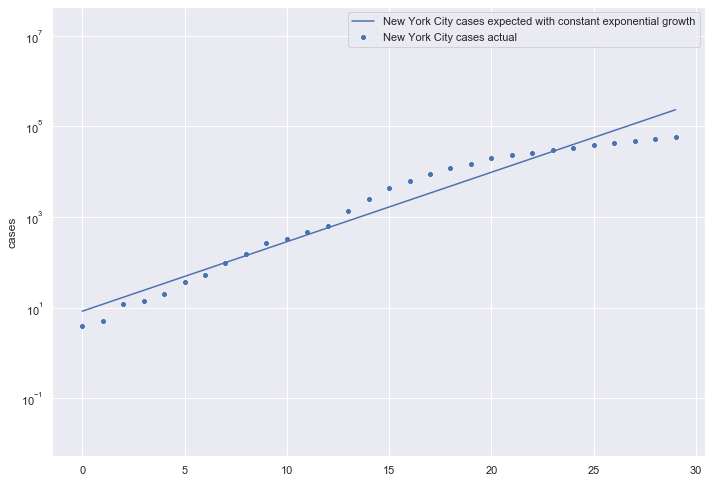

New York City deaths exponential formula fitted with 21 points:
deaths = 4.07 * exp(0.3419 * day)
fitted daily growth rate: 40.77 %, fitted days to doubling: 2.03
actual daily growth rate: 16.06 %, actual days to doubling: 4.32


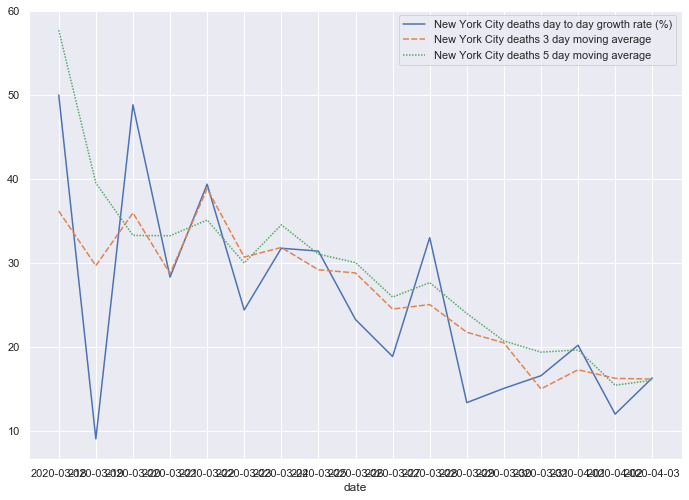

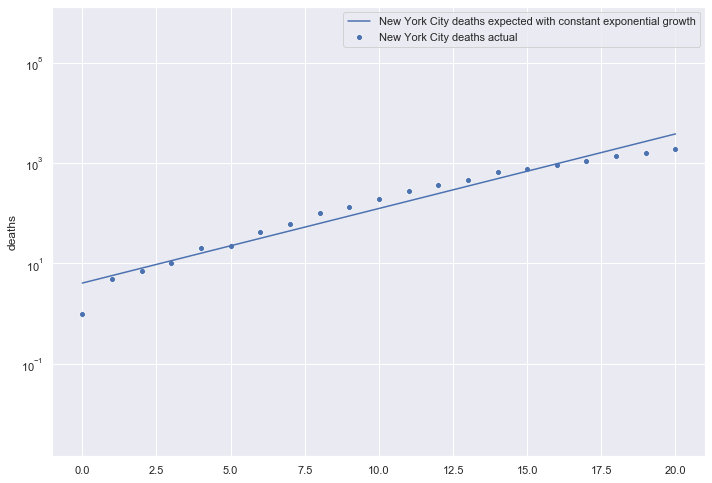

Trajectory plots for New York City, to see when the curve starts flattening


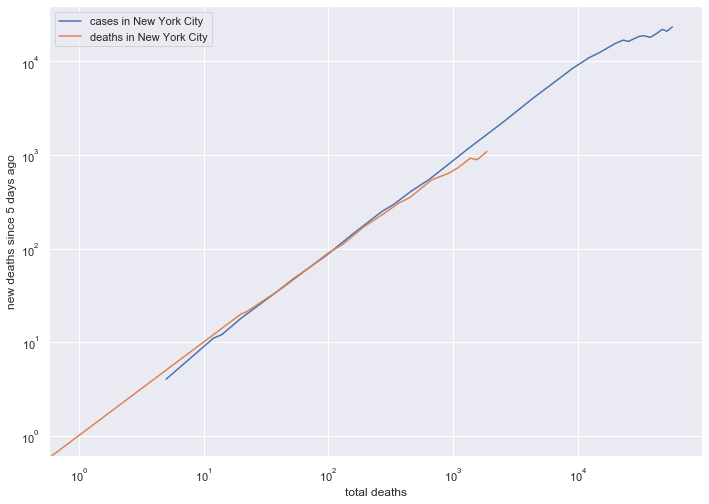

Correlations for New York City:


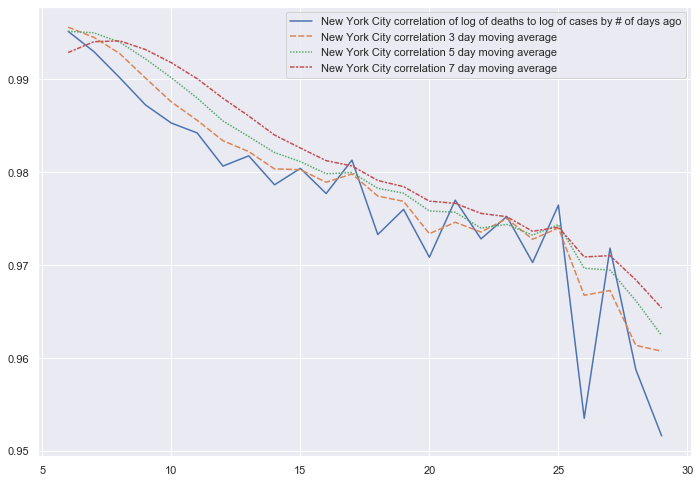

Deaths vs Lagged Values For New York City:


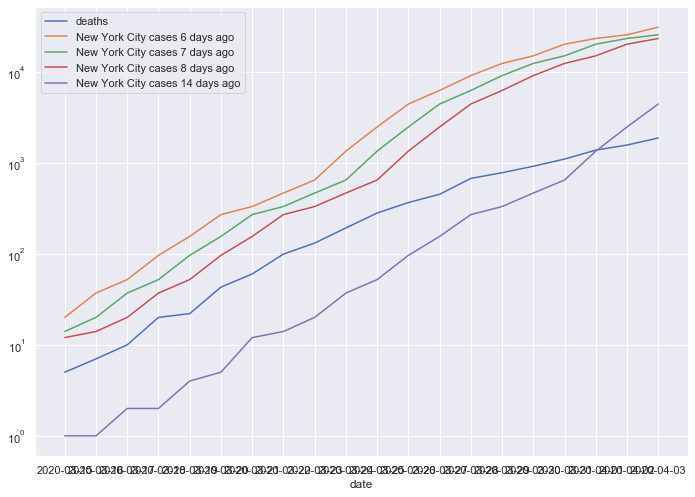

Deaths / Lagged Values For New York City:


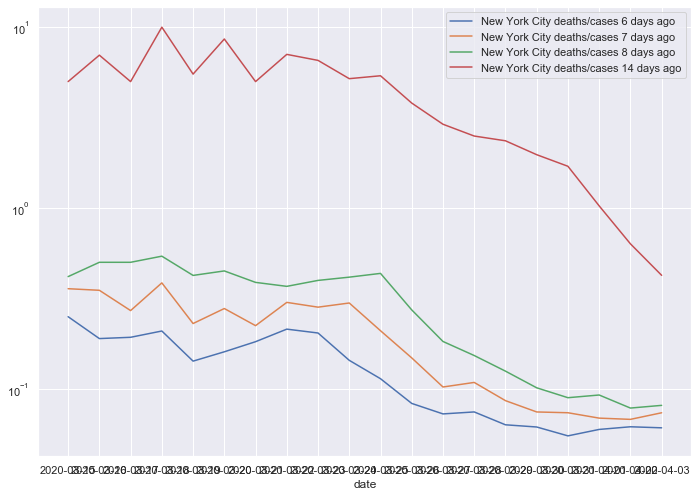


### Analysis for California ###

California cases exponential formula fitted with 30 points:
cases = 73.1 * exp(0.1856 * day)
fitted daily growth rate: 20.4 %, fitted days to doubling: 3.73
actual daily growth rate: 12.83 %, actual days to doubling: 5.4


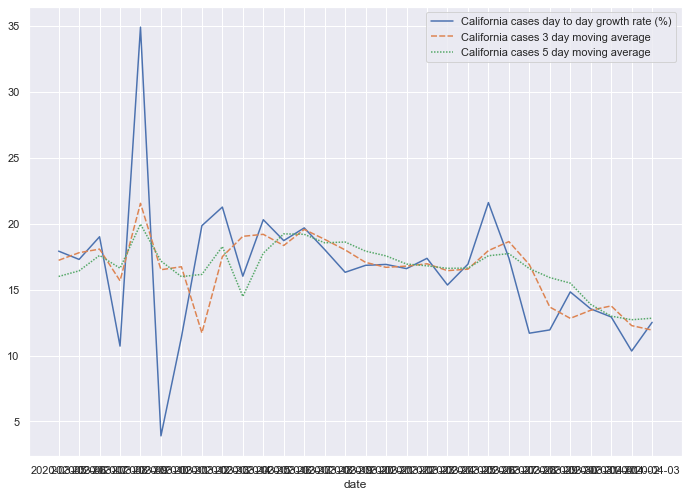

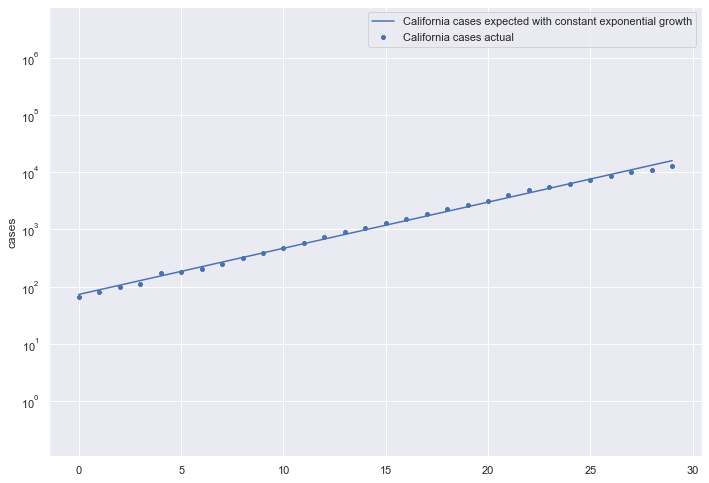

California deaths exponential formula fitted with 30 points:
deaths = 0.91 * exp(0.2079 * day)
fitted daily growth rate: 23.11 %, fitted days to doubling: 3.33
actual daily growth rate: 14.02 %, actual days to doubling: 4.94


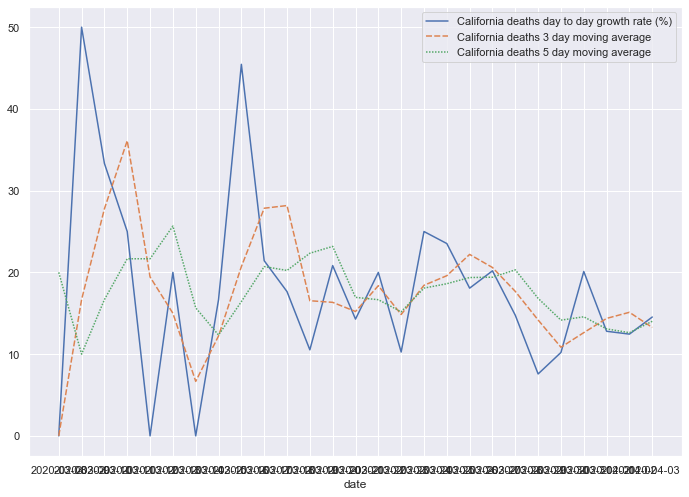

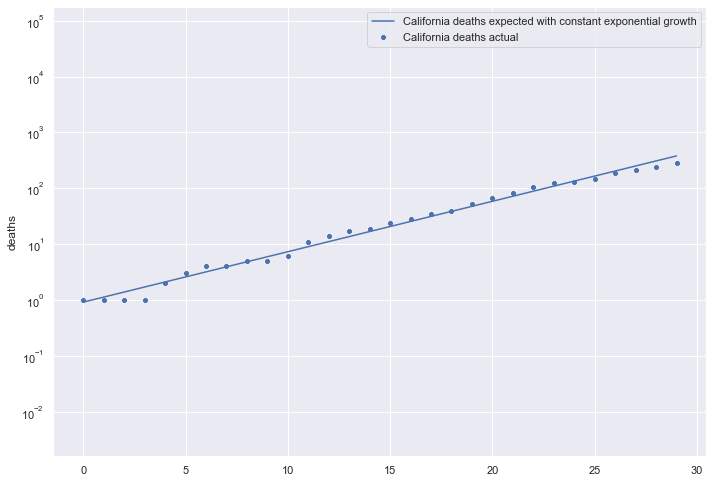

Trajectory plots for California, to see when the curve starts flattening


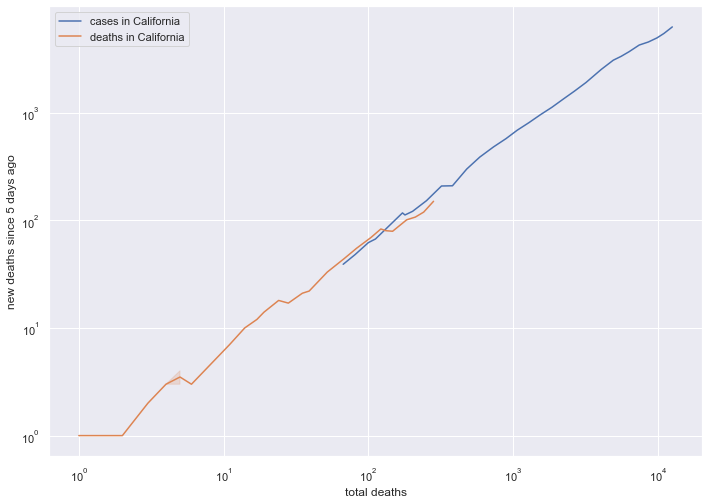

Correlations for California:


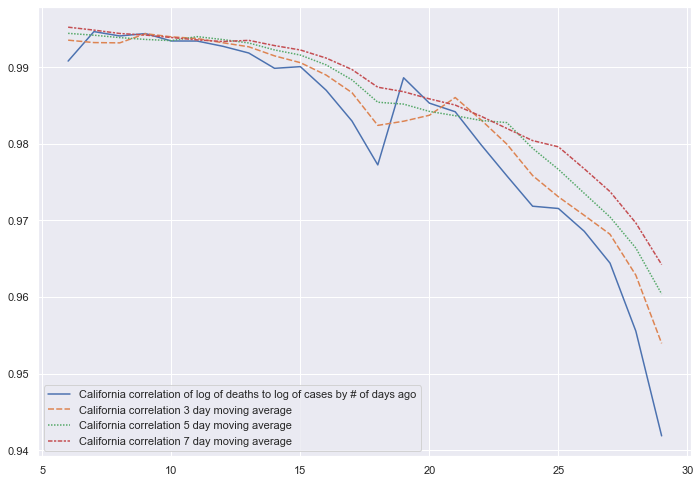

Deaths vs Lagged Values For California:


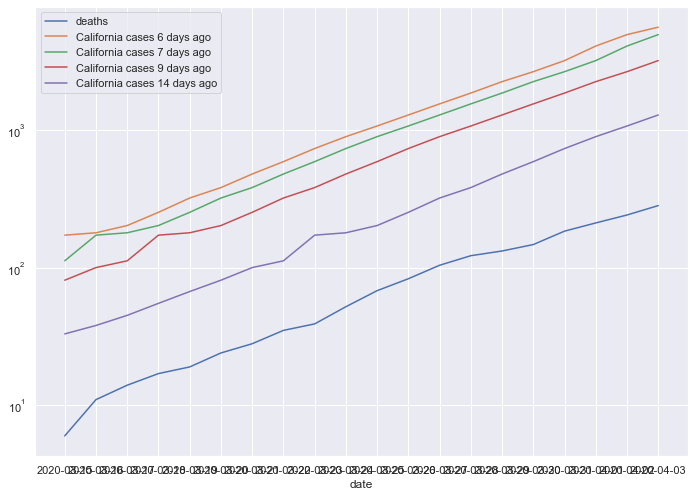

Deaths / Lagged Values For California:


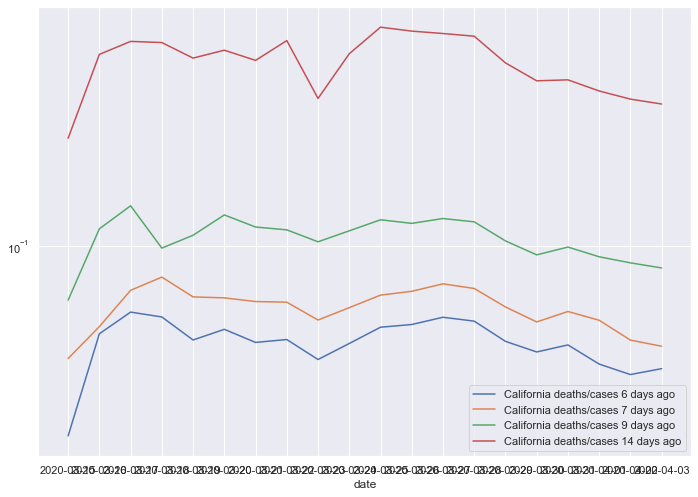


### Analysis for Colorado ###

Colorado cases exponential formula fitted with 30 points:
cases = 6.79 * exp(0.2458 * day)
fitted daily growth rate: 27.86 %, fitted days to doubling: 2.82
actual daily growth rate: 11.15 %, actual days to doubling: 6.22


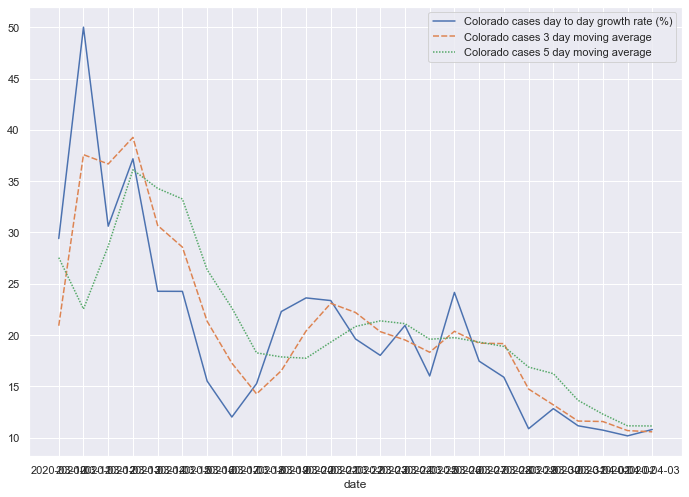

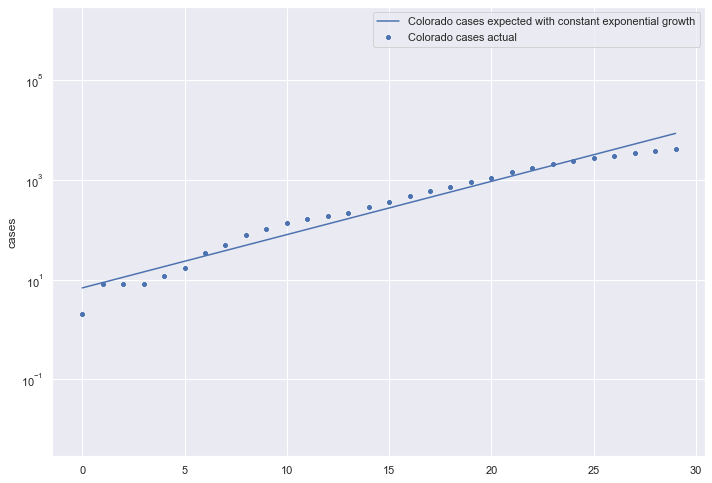

Colorado deaths exponential formula fitted with 23 points:
deaths = 1.04 * exp(0.2161 * day)
fitted daily growth rate: 24.12 %, fitted days to doubling: 3.21
actual daily growth rate: 15.77 %, actual days to doubling: 4.4


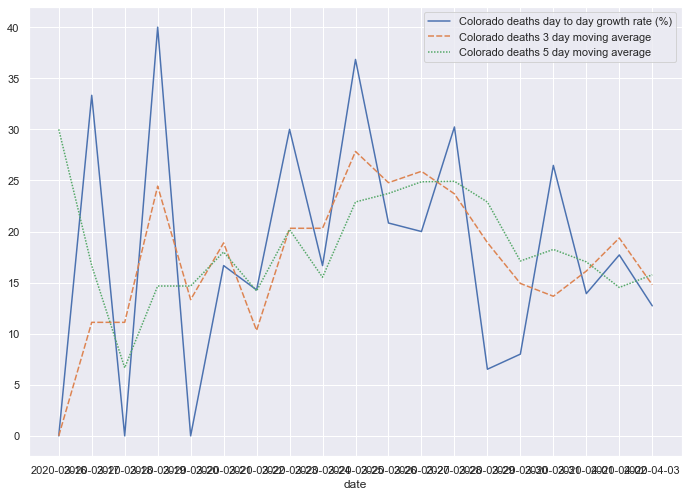

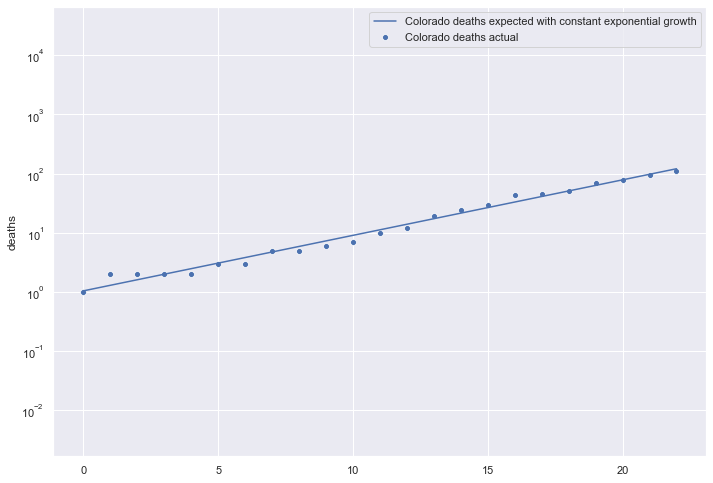

Trajectory plots for Colorado, to see when the curve starts flattening


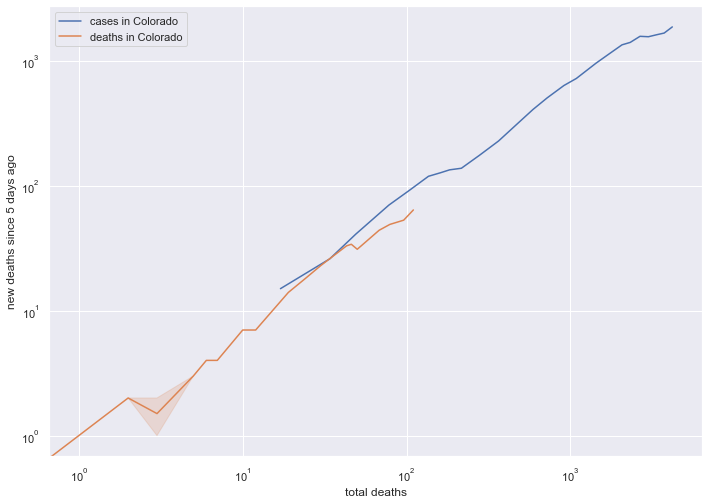

Correlations for Colorado:


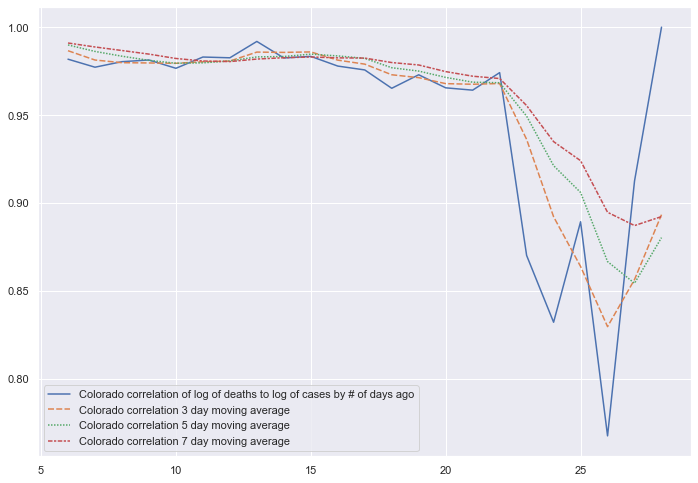

Deaths vs Lagged Values For Colorado:


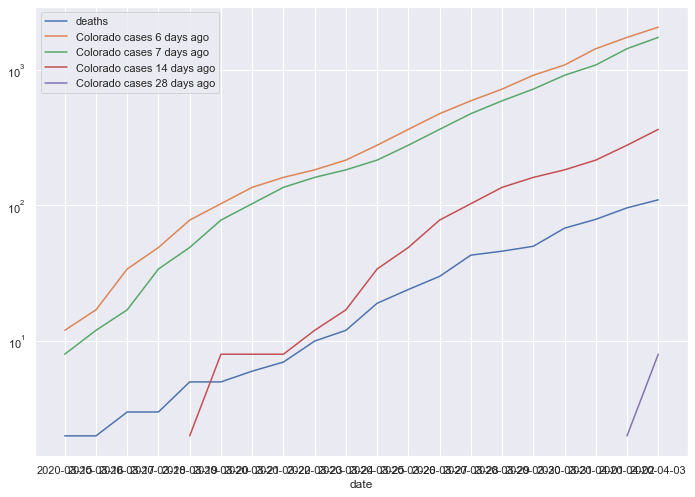

Deaths / Lagged Values For Colorado:


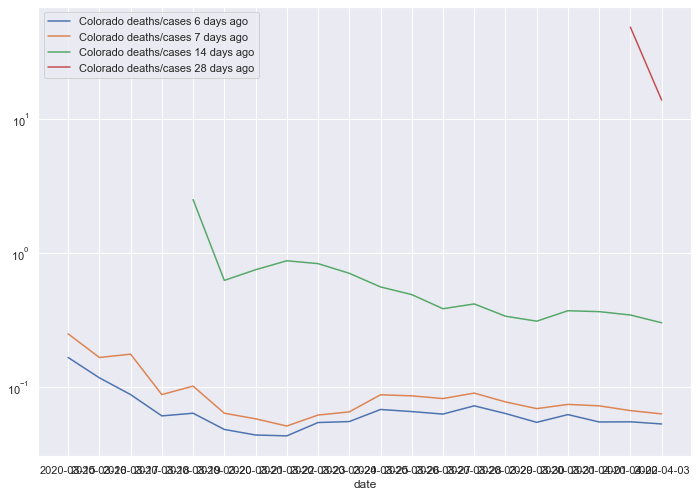


### Analysis for Arizona ###

Arizona cases exponential formula fitted with 30 points:
cases = 1.78 * exp(0.2524 * day)
fitted daily growth rate: 28.71 %, fitted days to doubling: 2.75
actual daily growth rate: 11.95 %, actual days to doubling: 5.8


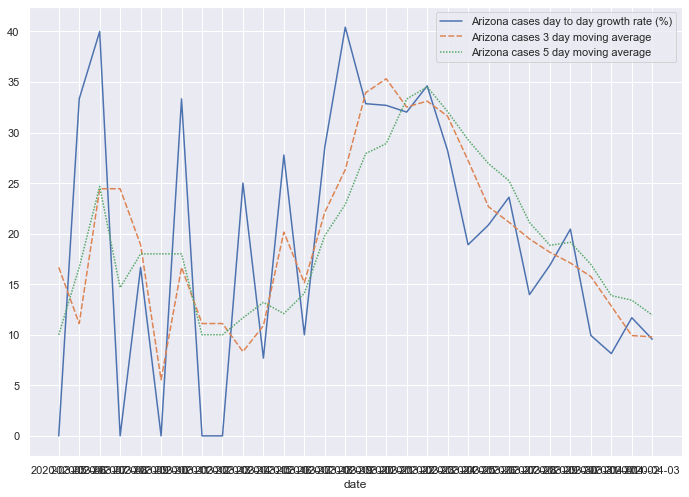

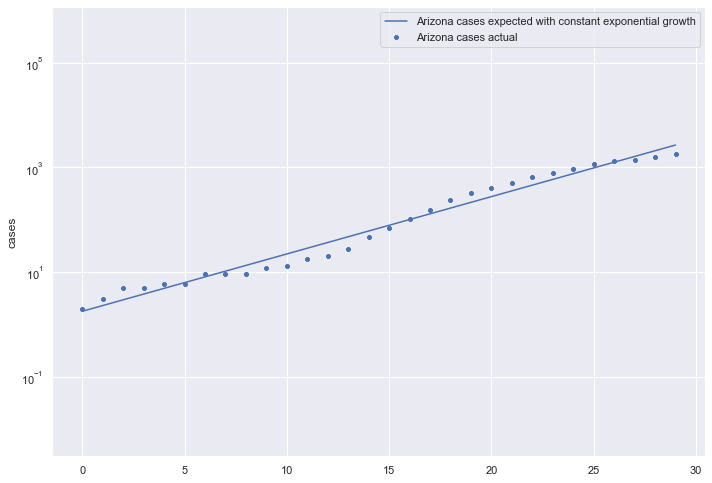

Arizona deaths exponential formula fitted with 15 points:
deaths = 1.02 * exp(0.2691 * day)
fitted daily growth rate: 30.88 %, fitted days to doubling: 2.58
actual daily growth rate: 20.03 %, actual days to doubling: 3.46


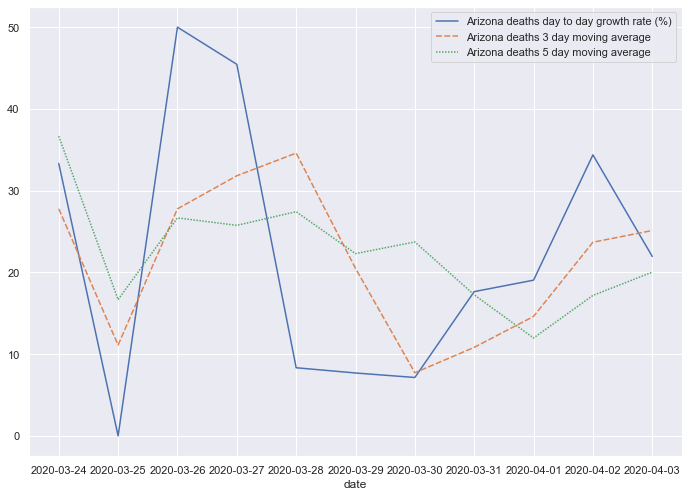

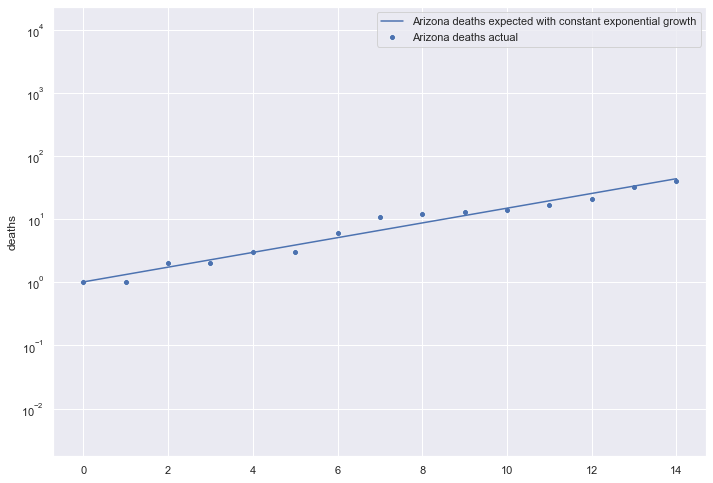

Trajectory plots for Arizona, to see when the curve starts flattening


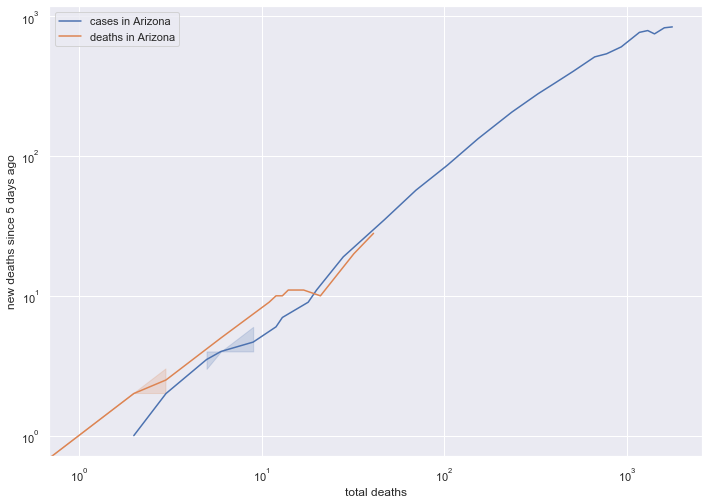

Correlations for Arizona:


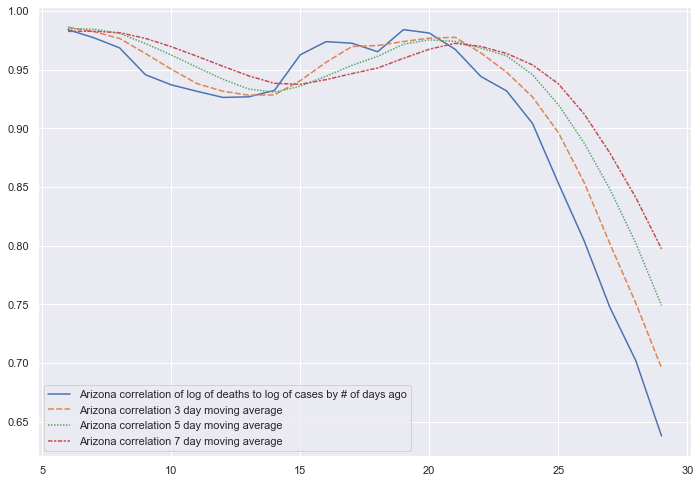

Deaths vs Lagged Values For Arizona:


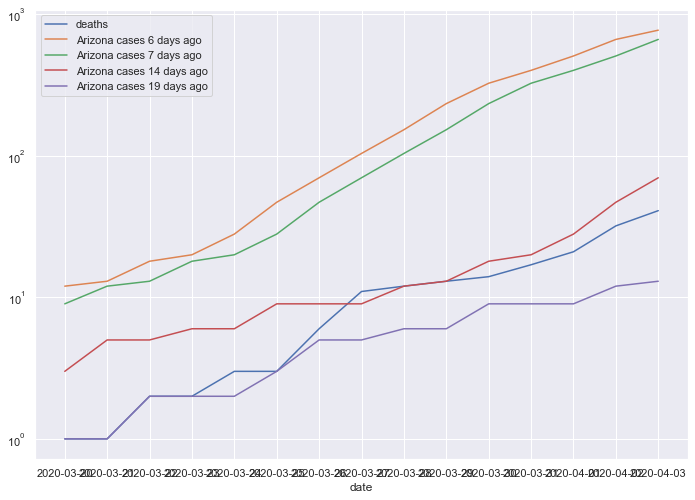

Deaths / Lagged Values For Arizona:


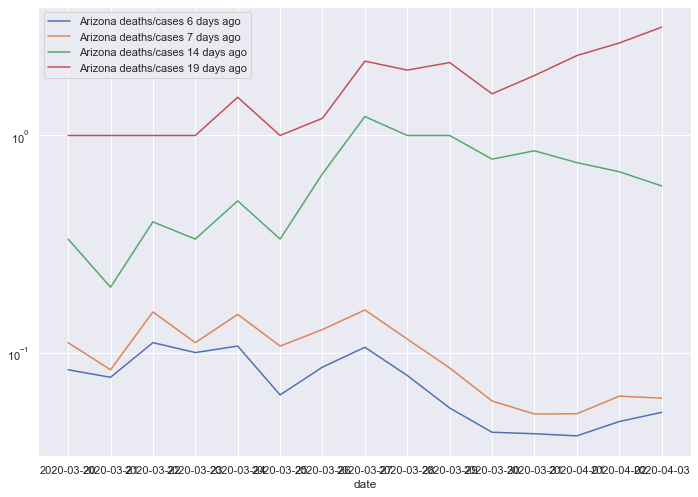


### Analysis for USA total: ###

USA total: cases exponential formula fitted with 30 points:
cases = 288.65 * exp(0.2574 * day)
fitted daily growth rate: 29.36 %, fitted days to doubling: 2.69
actual daily growth rate: 12.43 %, actual days to doubling: 5.58


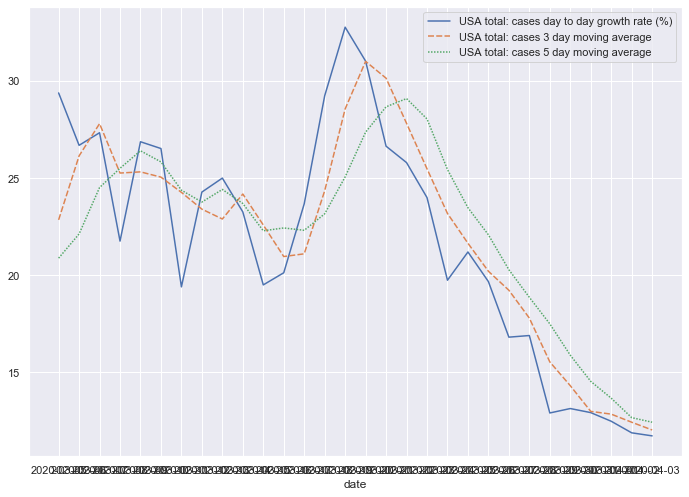

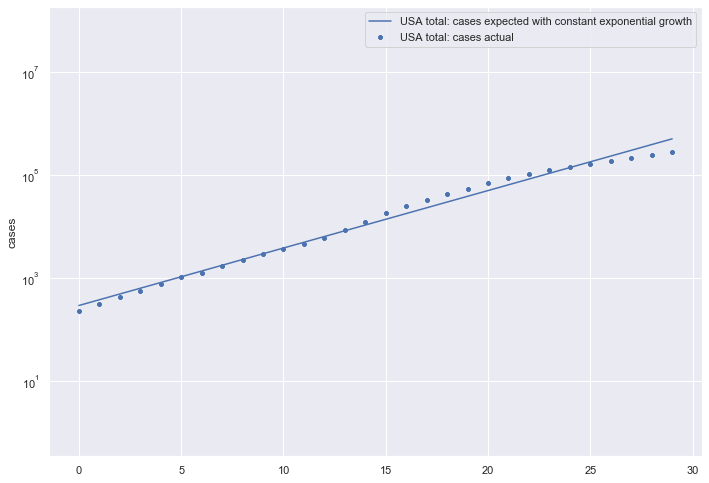

USA total: deaths exponential formula fitted with 30 points:
deaths = 9.57 * exp(0.2271 * day)
fitted daily growth rate: 25.5 %, fitted days to doubling: 3.05
actual daily growth rate: 19.47 %, actual days to doubling: 3.56


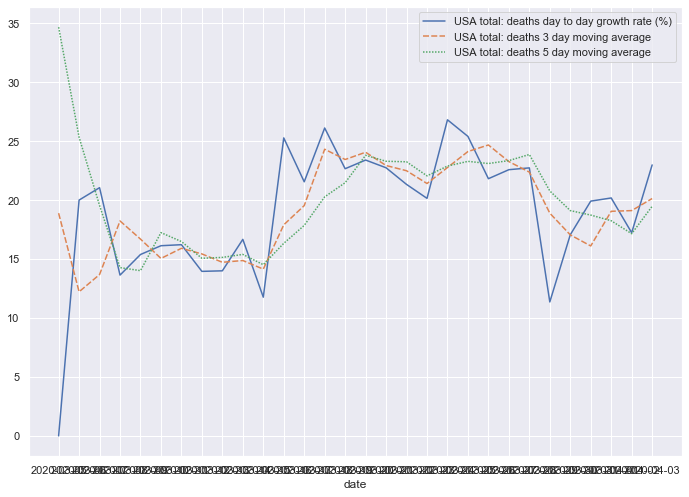

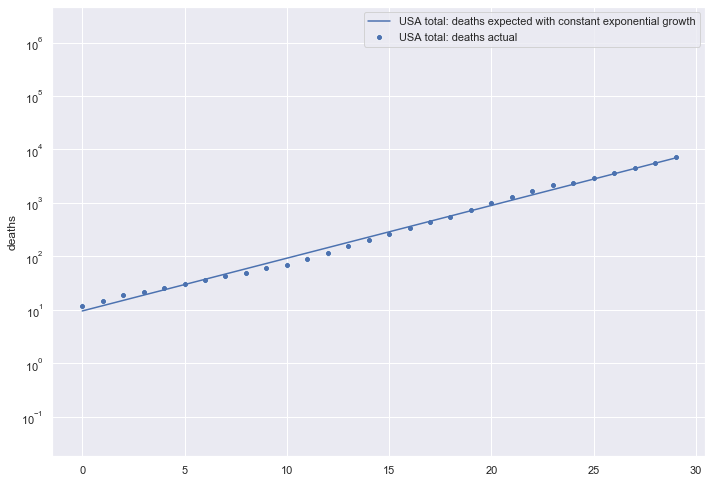

Trajectory plots for USA total:, to see when the curve starts flattening


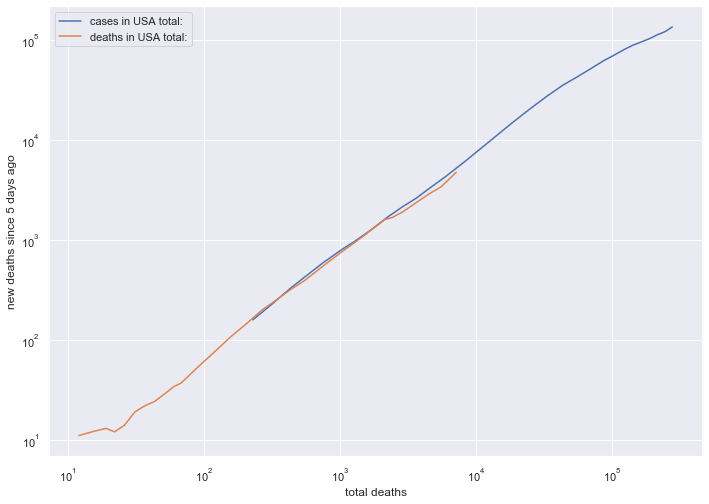

Correlations for USA total::


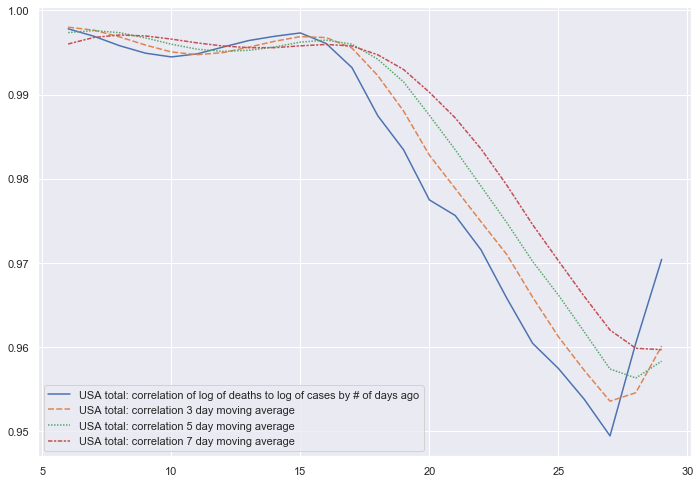

Deaths vs Lagged Values For USA total::


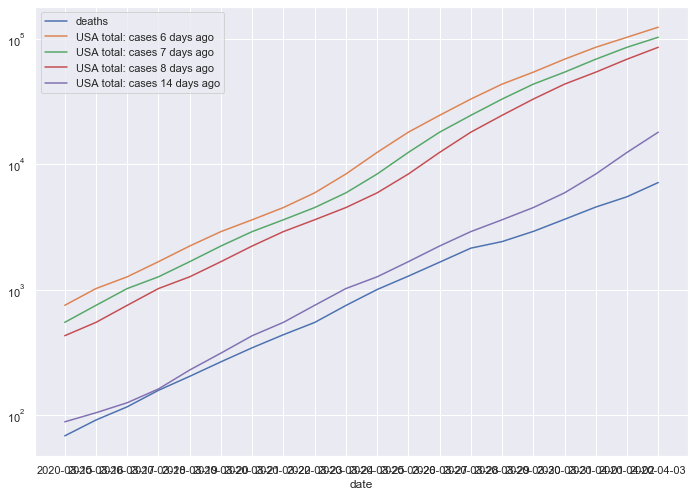

Deaths / Lagged Values For USA total::


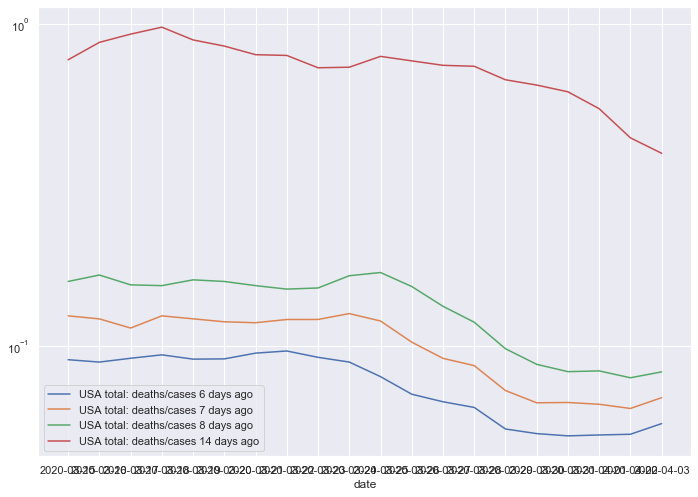

In [14]:
counties =["San Francisco", "Boulder", "Denver", "New York City"]
states = [ "California", "Colorado", "Arizona"]
analyse(counties=counties, states=states)

In [15]:
# counties with the most deaths today
today = rawData.tail(1).date.values[0]
rawData[rawData.date == today].groupby(['state', 'county']).sum().sort_values('deaths', ascending=False)

fips  cases  deaths
state         county                               
New York      New York City      0.0  57160    1867
              Unknown            0.0     37     608
Michigan      Wayne          26163.0   6096     223
Washington    King           53033.0   2789     188
Louisiana     Orleans        22071.0   3476     148
Illinois      Cook           17031.0   6473     141
New York      Nassau         36059.0  12024     138
Michigan      Oakland        26125.0   2540     136
New Jersey    Bergen         34003.0   4866     132
              Essex          34013.0   3067     118
New York      Suffolk        36103.0  10154      96
California    Los Angeles     6037.0   4566      89
Louisiana     Jefferson      22051.0   2495      85
Connecticut   Fairfield       9001.0   2717      76
New York      Westchester    36119.0  12350      67
Michigan      Macomb         26099.0   1560      65
New Jersey    Hudson         34017.0   2835      59
              Middlesex      34023.0   2125      56
              Monmouth       34025.0   1743      48
              Ocean          34029.0   1685      45
              Union          34039.0   2487      45
              Morris         34027.0   1298      43
New York      Rockland       36087.0   4289      42
Washington    Snohomish      53061.0   1449      41
Massachusetts Middlesex      25017.0   2202      39
California    Santa Clara     6085.0   1094      39
Nevada        Clark          32003.0   1279      39
New Jersey    Passaic        34031.0   2216      34
Florida       Palm Beach     12099.0    856      33
Indiana       Marion         18097.0   1429      33
...                              ...    ...     ...
Louisiana     Winn           22127.0      2       0
Maine         Androscoggin   23001.0     19       0
              Aroostook      23003.0      1       0
              Franklin       23007.0      4       0
Michigan      Allegan        26005.0      6       0
Massachusetts Nantucket      25019.0      9       0
              Dukes          25007.0      7       0
Maryland      Worcester      24047.0      5       0
              Washington     24043.0     27       0
              Talbot         24041.0      5       0
              St. Mary's     24037.0     30       0
              Somerset       24039.0      4       0
              Queen Anne's   24035.0     12       0
              Kent           24029.0      5       0
              Harford        24025.0     41       0
              Garrett        24023.0      3       0
              Dorchester     24019.0      1       0
              Caroline       24011.0      4       0
              Allegany       24001.0      2       0
Maine         Washington     23029.0      1       0
              Waldo          23027.0      3       0
              Unknown            0.0     11       0
              Somerset       23025.0      2       0
              Sagadahoc      23023.0     12       0
              Penobscot      23019.0     20       0
              Oxford         23017.0     10       0
              Lincoln        23015.0      8       0
              Knox           23013.0      9       0
              Hancock        23009.0      2       0
Wyoming       Washakie       56043.0      2       0

[2357 rows x 3 columns]

In [16]:
# counties with the most cases today
rawData[rawData.date == today].groupby(['state', 'county']).sum().sort_values('deaths', ascending=False)

fips  cases  deaths
state         county                               
New York      New York City      0.0  57160    1867
              Unknown            0.0     37     608
Michigan      Wayne          26163.0   6096     223
Washington    King           53033.0   2789     188
Louisiana     Orleans        22071.0   3476     148
Illinois      Cook           17031.0   6473     141
New York      Nassau         36059.0  12024     138
Michigan      Oakland        26125.0   2540     136
New Jersey    Bergen         34003.0   4866     132
              Essex          34013.0   3067     118
New York      Suffolk        36103.0  10154      96
California    Los Angeles     6037.0   4566      89
Louisiana     Jefferson      22051.0   2495      85
Connecticut   Fairfield       9001.0   2717      76
New York      Westchester    36119.0  12350      67
Michigan      Macomb         26099.0   1560      65
New Jersey    Hudson         34017.0   2835      59
              Middlesex      34023.0   2125      56
              Monmouth       34025.0   1743      48
              Ocean          34029.0   1685      45
              Union          34039.0   2487      45
              Morris         34027.0   1298      43
New York      Rockland       36087.0   4289      42
Washington    Snohomish      53061.0   1449      41
Massachusetts Middlesex      25017.0   2202      39
California    Santa Clara     6085.0   1094      39
Nevada        Clark          32003.0   1279      39
New Jersey    Passaic        34031.0   2216      34
Florida       Palm Beach     12099.0    856      33
Indiana       Marion         18097.0   1429      33
...                              ...    ...     ...
Louisiana     Winn           22127.0      2       0
Maine         Androscoggin   23001.0     19       0
              Aroostook      23003.0      1       0
              Franklin       23007.0      4       0
Michigan      Allegan        26005.0      6       0
Massachusetts Nantucket      25019.0      9       0
              Dukes          25007.0      7       0
Maryland      Worcester      24047.0      5       0
              Washington     24043.0     27       0
              Talbot         24041.0      5       0
              St. Mary's     24037.0     30       0
              Somerset       24039.0      4       0
              Queen Anne's   24035.0     12       0
              Kent           24029.0      5       0
              Harford        24025.0     41       0
              Garrett        24023.0      3       0
              Dorchester     24019.0      1       0
              Caroline       24011.0      4       0
              Allegany       24001.0      2       0
Maine         Washington     23029.0      1       0
              Waldo          23027.0      3       0
              Unknown            0.0     11       0
              Somerset       23025.0      2       0
              Sagadahoc      23023.0     12       0
              Penobscot      23019.0     20       0
              Oxford         23017.0     10       0
              Lincoln        23015.0      8       0
              Knox           23013.0      9       0
              Hancock        23009.0      2       0
Wyoming       Washakie       56043.0      2       0

[2357 rows x 3 columns]